## Notebook Objectives

Summarize the Necessary Knowleadge to Apply Clustering Models in Businesses


### About the Models

&emsp;&emsp;_How It Works_    
&emsp;&emsp;_When to Use it_    
&emsp;&emsp;_Advantages_    
&emsp;&emsp;_Disadvantages_    
&emsp;&emsp;_Statistical Assumptions_    
&emsp;&emsp;_Parameters_    
&emsp;&emsp;_More Explanations_

[K-Means](#K-Means)<br>
[DBSCAN](#DBSCAN)<br>
[AgglomerativeClustering](#AgglomerativeClustering)<br>

### Agenda

[Business Questions](#Business-Questions)<br>

[Imports](#Imports)<br>
&emsp;[Functions](#Functions)<br>
&emsp;[Settings](#Settings)<br>

[Loading Data](#Loading-Data)<br>

[Feature Engineering](#Feature-Engineering)<br>

[Preprocessing](#Preprocessing)<br>
&emsp;[Handling Missing Values](#Handling-Missing-Values)<br>
&emsp;[Encoding Categorical Variables](#Encoding-Categorical-Variables)<br>
&emsp;[Scaling/Normalizing Features](#Scaling/Normalizing-Features)<br>
&emsp;[Handling Outliers](#Handling-Outliers)<br>

[Feature Selection](#Feature-Selection)<br>

[Models](#Models)<br>
&emsp;[Choosing The Right Clustering Algorithm](#Choosing-The-Right-Clustering-Algorithm)<br>
&emsp;[K-Means](#K-Means)<br>
&emsp;[DBSCAN](#DBSCAN)<br>
&emsp;[AgglomerativeClustering](#AgglomerativeClustering)<br>

[Evaluation Metrics](#Evaluation-Metrics)<br>
&emsp;[Choosing the Right Metric](#Choosing-the-Right-Metric)<br>

[Feature Importances](#Feature-Importances)<br>

[Cluster Analysis](#Cluster-Analysis)<br>
&emsp;[Cluster Profiles](#Cluster-Profiles)<br>


## Business Questions

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D  # Ensure you import Axes3D


from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

from sklearn.preprocessing import MinMaxScaler


### Functions

In [29]:
def plot_cluster_boxplots(data, cluster_col, variable_a, variable_b, showfliers=False, horizontal_line_at=0):
    """
    Plot boxplots for sales and profit by cluster.

    Parameters:
    - data: DataFrame containing the dataset.
    - cluster_col: The name of the column representing cluster labels.
    - variable_a: The name of the column representing variable_a
    - variable_b: The name of the column representing variable_b
    """
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    sns.boxplot(x=cluster_col, y=variable_a, data=data, showfliers=showfliers)
    plt.title(f'{variable_a} by {cluster_col}')

    plt.subplot(1, 2, 2)
    sns.boxplot(x=cluster_col, y=variable_b, data=data, showfliers=showfliers)
    plt.title(f'{variable_b} by {cluster_col}')
    
    plt.axhline(horizontal_line_at, color='r')

    plt.tight_layout()
    plt.show()


def plot_cluster_analysis(data, cluster_col, variable_a, variable_b, palette='mako'):
    """
    Plot countplot for clusters and scatterplot for recency vs frequency by cluster.

    Parameters:
    - data: DataFrame containing the dataset.
    - cluster_col: The name of the column representing cluster labels.
    - variable_a: The name of the column representing variable_a.
    - variable_b: The name of the column representing variable_b.
    - palette: Color palette for the plots (default is 'mako').
    """
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    sns.countplot(x=cluster_col, data=data, palette=palette)
    plt.title(f'Count of {cluster_col} Clusters')

    plt.subplot(1, 2, 2)
    sns.scatterplot(data=data, x=variable_a, y=variable_b, hue=cluster_col, palette=palette)
    plt.title(f'{variable_a} vs {variable_b} by {cluster_col}')

    plt.tight_layout()
    plt.show()

### Settings

In [2]:
pd.set_option("display.max_columns", None)

### Loading Data

In [3]:
# https://www.kaggle.com/datasets/jr2ngb/superstore-data
df_superstore = pd.read_csv("../data/superstore_dataset2011-2015.csv", encoding = "ISO-8859-1")
print(df_superstore.shape)
df_superstore.head(2)

(51290, 24)


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,Country,Postal Code,Market,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority
0,42433,AG-2011-2040,1/1/2011,6/1/2011,Standard Class,TB-11280,Toby Braunhardt,Consumer,Constantine,Constantine,Algeria,NaN,Africa,Africa,OFF-TEN-10000025,Office Supplies,Storage,"Tenex Lockers, Blue",408.300,2,0.0,106.140,35.46,Medium
1,22253,IN-2011-47883,1/1/2011,8/1/2011,Standard Class,JH-15985,Joseph Holt,Consumer,Wagga Wagga,New South Wales,Australia,NaN,APAC,Oceania,OFF-SU-10000618,Office Supplies,Supplies,"Acme Trimmer, High Speed",120.366,3,0.1,36.036,9.72,Medium


## Feature Engineering

In [4]:
df_customer_abt = (
    df_superstore
        .groupby('Customer ID')
        .agg(
            total_sales=('Sales', 'sum'),
            avg_ticket=('Sales', 'mean'),
            total_products=('Quantity', 'sum'),
            avg_produtcs_per_purchase=('Quantity', 'mean'),
            median_discount=('Discount', 'median'),
            avg_discount=('Discount', 'mean'),
            std_discount=('Discount', 'std'),
            total_profit=('Profit', 'sum'),
            avg_profit=('Profit', 'mean'),
            total_shipping_cost=('Shipping Cost', 'sum'),
            avg_shipping_cost=('Shipping Cost', 'mean'),
        ).reset_index()
)
print(df_customer_abt.shape)
df_customer_abt.head(2)

(1590, 12)


,Customer ID,total_sales,avg_ticket,total_products,avg_produtcs_per_purchase,median_discount,avg_discount,std_discount,total_profit,avg_profit,total_shipping_cost,avg_shipping_cost
0,AA-10315,13747.413,327.319357,145,3.452381,0.0,0.103571,0.159034,447.6905,10.659298,1236.15,29.432143
1,AA-10375,5884.195,140.099881,139,3.309524,0.0,0.166667,0.218271,677.4774,16.130414,903.92,21.521905


## Preprocessing

### Handling Missing Values

In [5]:
df_customer_abt = df_customer_abt.dropna()
df_customer_abt.shape

(1583, 12)

### Encoding Categorical Variables

### Handling Outliers

## Feature Selection

In [6]:
features = (
    df_customer_abt.select_dtypes('number')
                    # .drop(columns=['Customer ID'])
                    .columns
                    .to_list()
)

# features = ['Sales', 'Quantity', 'Discount', 'Profit', 'Shipping Cost']

df_customer_abt[features].head(2)

,total_sales,avg_ticket,total_products,avg_produtcs_per_purchase,median_discount,avg_discount,std_discount,total_profit,avg_profit,total_shipping_cost,avg_shipping_cost
0,13747.413,327.319357,145,3.452381,0.0,0.103571,0.159034,447.6905,10.659298,1236.15,29.432143
1,5884.195,140.099881,139,3.309524,0.0,0.166667,0.218271,677.4774,16.130414,903.92,21.521905


### Scaling/Normalizing Features

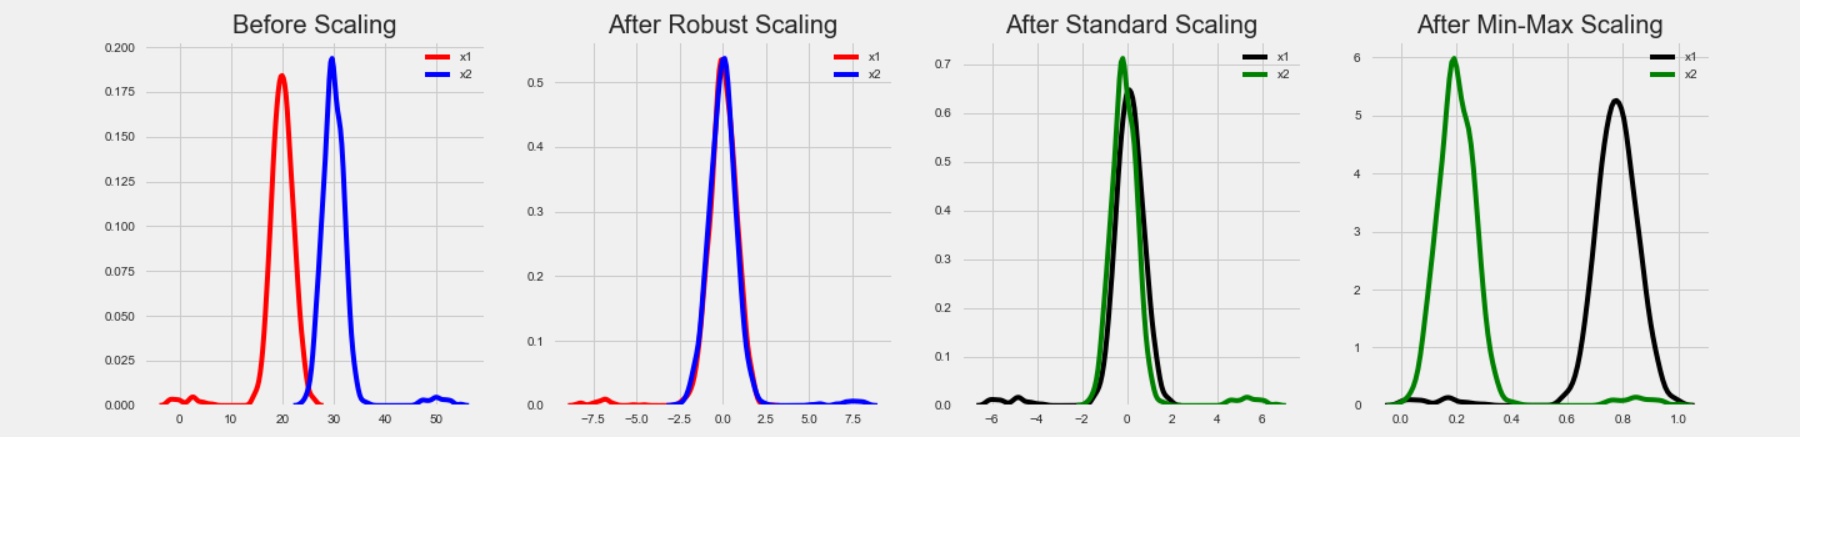

In [7]:
scaler = MinMaxScaler()
df_customer_abt_scaled = scaler.fit_transform(df_customer_abt[features])

## Models

### Choosing The Right Clustering Algorithm

### K-Means


**How It Works:** StatQuest: K-means clustering (https://www.youtube.com/watch?v=4b5d3muPQmA&t)



- **When to Use it:**

    Useful in scenarios where you expect clusters to have somewhat spherical shape (convex data) and roughly equal sizes.    

    When Data Points naturally form distinct, well-separated spherical clusters.    


- **Advantages**

    Easy to Interpret: K-means provides clear cluster centers, making it easier to interpret clusters and use them for subsequent tasks like classification or segmentation.    

    Scalability (It's Fast): ideal for large datasets due to its computational efficiency.    


- **Disadvantages**


    Assumption of Spherical Clusters: it performs poorly with (non-convex data) elongated or irregularly shaped clusters.    
    
    Sensitivity to Outliers: because it uses the "mean" to readjust clusters, centroids can be dragged by outliers, distorting the centroids.       

    Sensitive to Initialization: results depend heavily on the initial positions of centroids.   

    Cluster Size Imbalance: it tends to split larger clusters and merge smaller ones, failing to properly represent data with clusters of unequal sizes. Ex: a dataset with one large group of 10,000 points and a smaller group of 100 points. K-means might allocate multiple centroids to the larger group while merging the smaller group into another cluster, and that's because We set the quantity of clusters beforehand.

    Lacks Consistency: it gives varying results on different runs of an algorithm.   

    



- **Statistical Assumptions**

    Clusters are Spherical
    
    Homoscedasticidy: variable have the same variance. The spread or dispersion of the data points is consistent across all variables (it is uniform in all dimensions). The variance is the same in all directions from the center of the cluster. This  assumption is important because it ensures thateach feature contributes equally to the analysis. High variance affects the model because it causes a variable to have outliers which affects the mean (disproportionately influencing the estimates of model parameters).    

    Linear Separability: K-means assumes that clusters are linearly separable. Each cluster can be separated from others by a straight line (in two dimensions) or a hyperplane (in higher dimensions). Therefore spiral clusters are not a good match for K-means.    

    "Mean" as a Good Cluster Representation: K-means relies on centroids, meaning it works best when the mean is a meaningful representation of the cluster. Example: when data is symmetrically distributed (equal mean, median and mode, making the centroid (mean) a good representative).    

    Variables are Independent: each variable provides unique information and knowing the value of one variable does not give any information about the value of another variable. Highly correlated features can distort the distance metric and affect clustering results. Correlated features provide redundant information, which can lead to overemphasis on certain dimensions (giving indue weight to these features and skewing the clustering results). Besides, they can result in elogated/elliptical clusters. Thus, the centroids may not accuratly represent the true center of the clusters.    

    Prior probability for all clusters are the same: each cluster has roughly equal number of observations. "You don't have any reason to believe one cluster is more likely than another, you assume each cluster has an equal chance of containing any given data point". K-means minimizes the sum of squared distances. The centroid of each cluster is updated by calculating the mean of all points assigned to that cluster (this new centroid minimizes the SSD for the current cluster assignment) and this averaging process assumes that all points within a cluster contribute equally. So, k-Means assumes each cluster has the same size because the distance metric (using the mean) assumes it.    

    Feature Importance/Scaling: K-means typically uses Euclidean distance, so it assumes data features are equally scaled. Features with larger ranges can dominate the distance calculation, leading to biased results. Proper normalization (or standardization) is essential.    

    


- **Parameters**

    K: number of clusters you want to segment the data.    
    
        How to to choose K:
            Elbow Method: Plot the (inertia) sum of squared distances (SSD) for different K values and look for the "elbow point" where the rate of decrease slows down. You can also use distortion, the average of squared distances, to emphasize similarity between observations in the cluster.    

            Silhouette Score: Measures how similar points are within their own cluster compared to other clusters.    

    Max Iterations: the maximum number of iterations the algorithm will run to refine the centroids. It can prevent the algorithm from running indefinitely in case it doesn’t converge.

    Initialization Method: centroid initialization. It determines how to initialize the centroids before starting the K-means algorithm.
    
        The two main options are:
            Random Initialization: Centroids are chosen randomly from the data points. This can lead to poor results or slow convergence.
            
            K-means++ Initialization: A smarter way to initialize centroids by spreading them out, which tends to result in better clustering and faster convergence.


- **More Explanations**

    Manhattan Distance vs Euclidean Distance: manhattan for high dimensionality, as high dimensionality often leads to difficulty in distinguishing distances between one point and the other. Manhattan does better than Euclidean once we move up to higher dimensional space because each dimension contributes linearly to the distance (avoiding quadratic amplification of differences as seen in Euclidean Distance), providing more balanced distances and reducing the impact of dominant dimensions or outliers.

    Inertia VS Distortion: choosing K number of clusters (Elbow Method).     
        
        Inertia is defined as the sum of squared distances from each point to its cluster centroid.    
        Smaller values correspond to tighter clusters, this means we are penalizing spread out clusters and rewarding compact clusters (tighter to their centroid).    
        It's sensitive to the dataset size (due to the sum). The more observations you add the more you'll penalize the inertia, even if observations are closer to the centroid.    

        Distortion is the average of squared distances from each point to its cluster centroid.    
        Smaller values also correspond to tighter clusters. It is not penalized as more observations are added (because it calculates the average) and closer points to the centroid will actually reward distortion (whereas inertia also depends on the number of points and no tonly the distance)    

        When the similarity of the cluster members are relevant, you should use distortion.    
        If you're more concerned that clusters should have a similar number of members, use inertia then.    

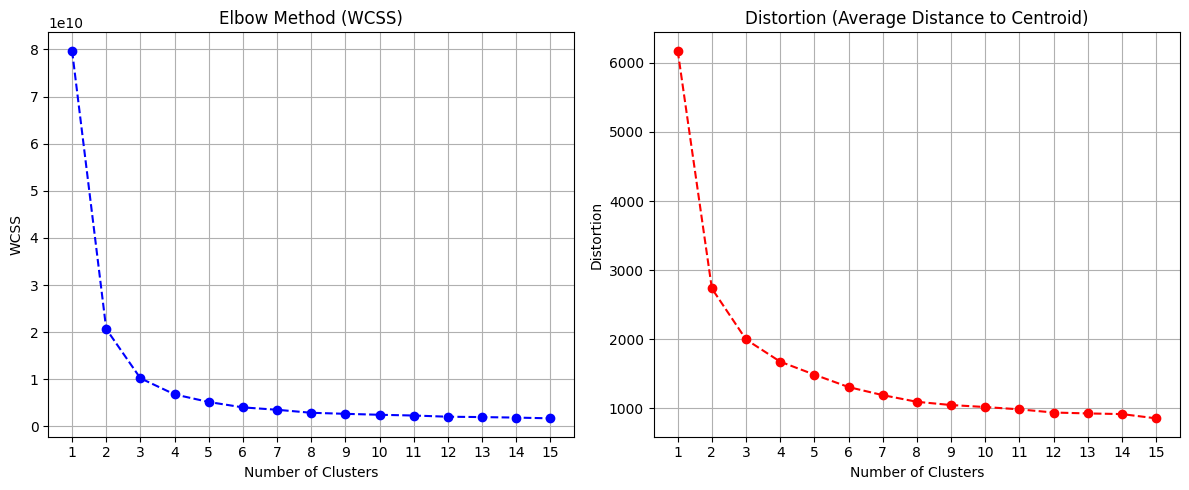

In [13]:
# Within-Cluster Sum of Squares.
wcss = [] 
distortions = []
max_clusters = 15


# Loop through different cluster counts
for i in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=i, random_state=42, max_iter=500)
    kmeans.fit(df_customer_abt[features])
    wcss.append(kmeans.inertia_)
    
    # Distortion (Average Distance to Centroid)
    _, distances = pairwise_distances_argmin_min(df_customer_abt[features], kmeans.cluster_centers_)
    distortions.append(np.mean(distances))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, max_clusters + 1), wcss, marker='o', linestyle='--', color='b')
plt.title('Elbow Method (WCSS)')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.xticks(range(1, max_clusters + 1))
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(range(1, max_clusters + 1), distortions, marker='o', linestyle='--', color='r')
plt.title('Distortion (Average Distance to Centroid)')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.xticks(range(1, max_clusters + 1))
plt.grid()

plt.tight_layout()
plt.show()

C:\Users\preis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\preis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\preis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

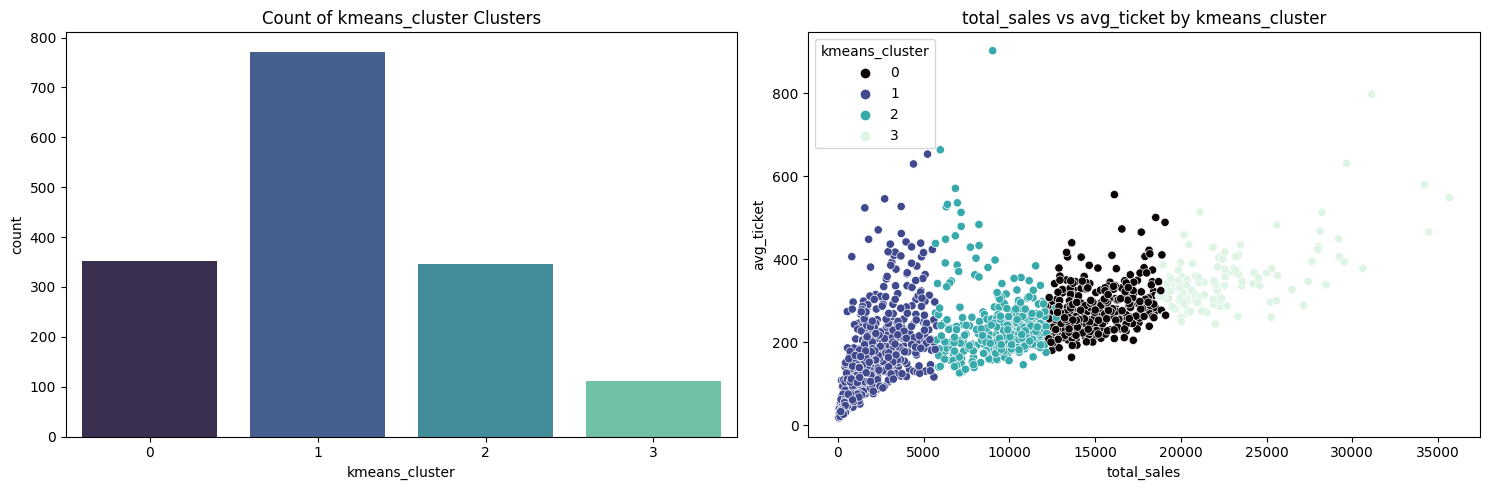

CPU times: total: 1.34 s
Wall time: 543 ms


In [37]:
%%time
kmeans = KMeans(n_clusters=4, random_state=42, max_iter=500)
df_customer_abt['kmeans_cluster'] = kmeans.fit_predict(df_customer_abt[features])

plot_cluster_analysis(df_customer_abt, 'kmeans_cluster', 'total_sales', 'avg_ticket', palette='mako')

C:\Users\preis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\preis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\preis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

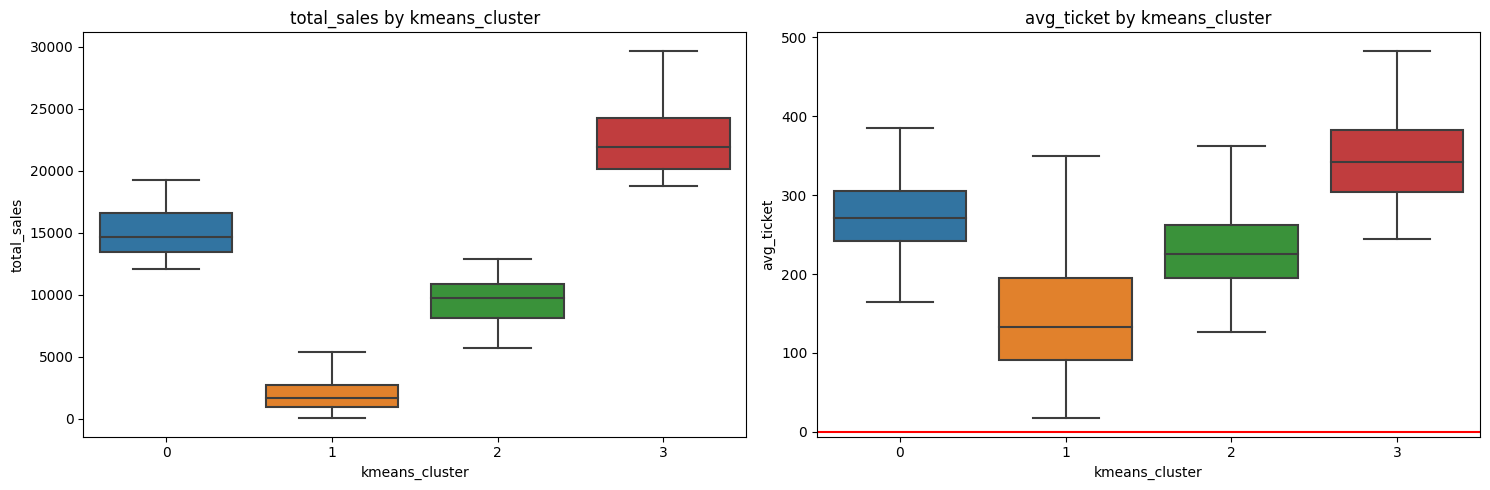

In [39]:
plot_cluster_boxplots(df_customer_abt, 'kmeans_cluster', 'total_sales', 'avg_ticket')

In [36]:
df_customer_abt.columns

Index(['Customer ID', 'total_sales', 'avg_ticket', 'total_products',
       'avg_produtcs_per_purchase', 'median_discount', 'avg_discount',
       'std_discount', 'total_profit', 'avg_profit', 'total_shipping_cost',
       'avg_shipping_cost', 'kmeans_cluster'],
      dtype='object')

C:\Users\preis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\preis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\preis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

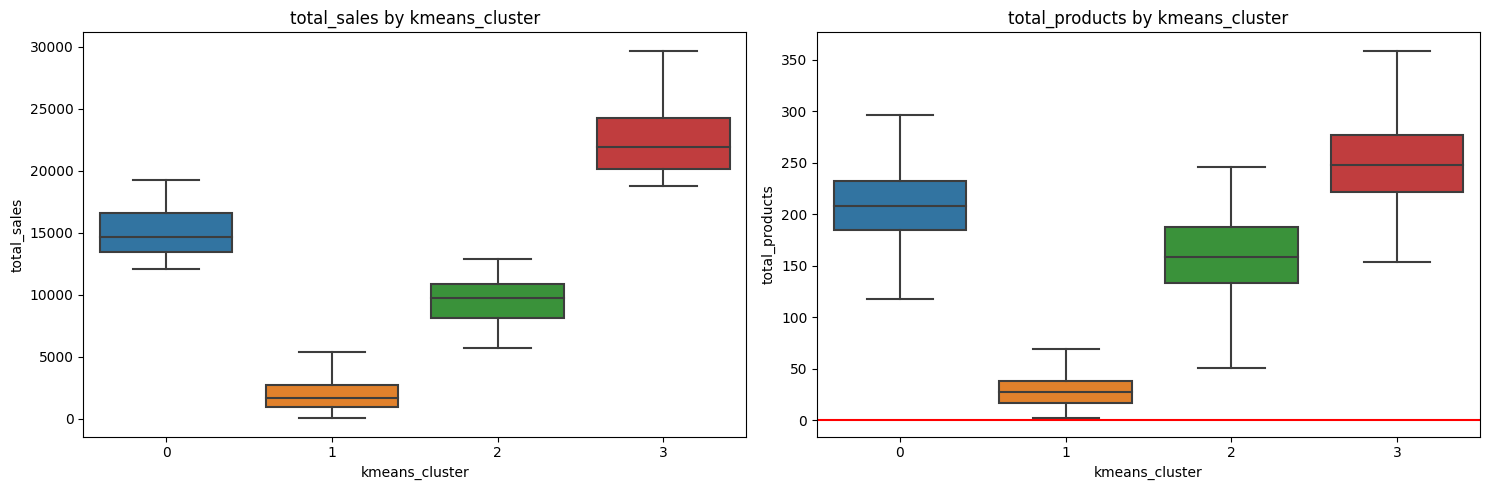

In [40]:
plot_cluster_boxplots(df_customer_abt, 'kmeans_cluster', 'total_sales', 'total_products')

C:\Users\preis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\preis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\preis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

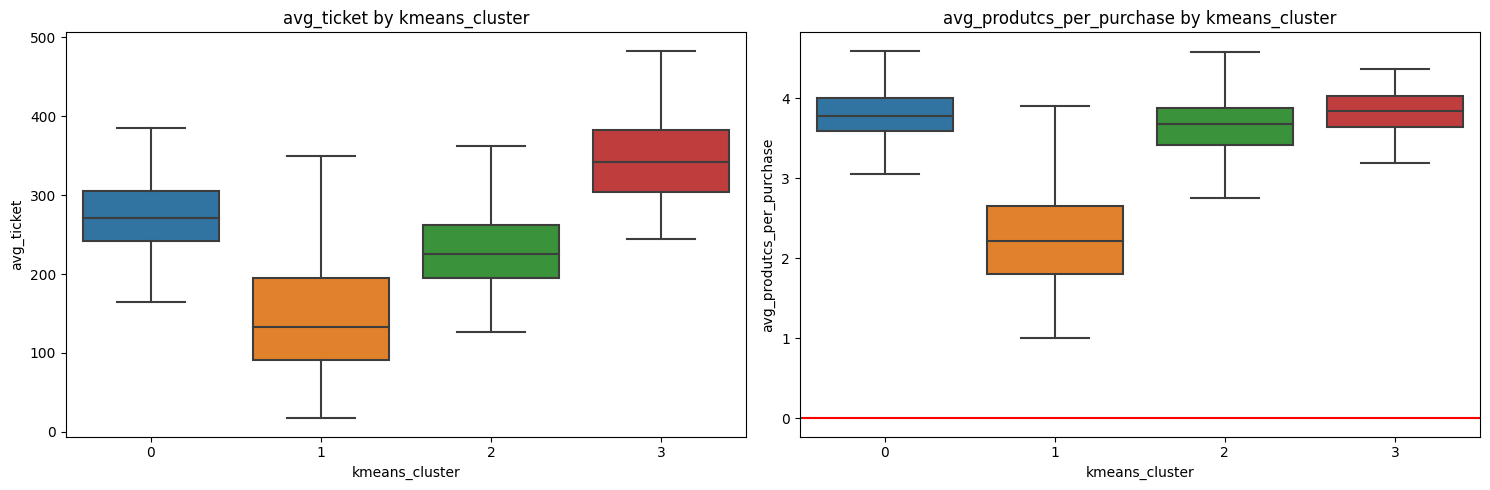

In [41]:
plot_cluster_boxplots(df_customer_abt, 'kmeans_cluster', 'avg_ticket', 'avg_produtcs_per_purchase')

C:\Users\preis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\preis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\preis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

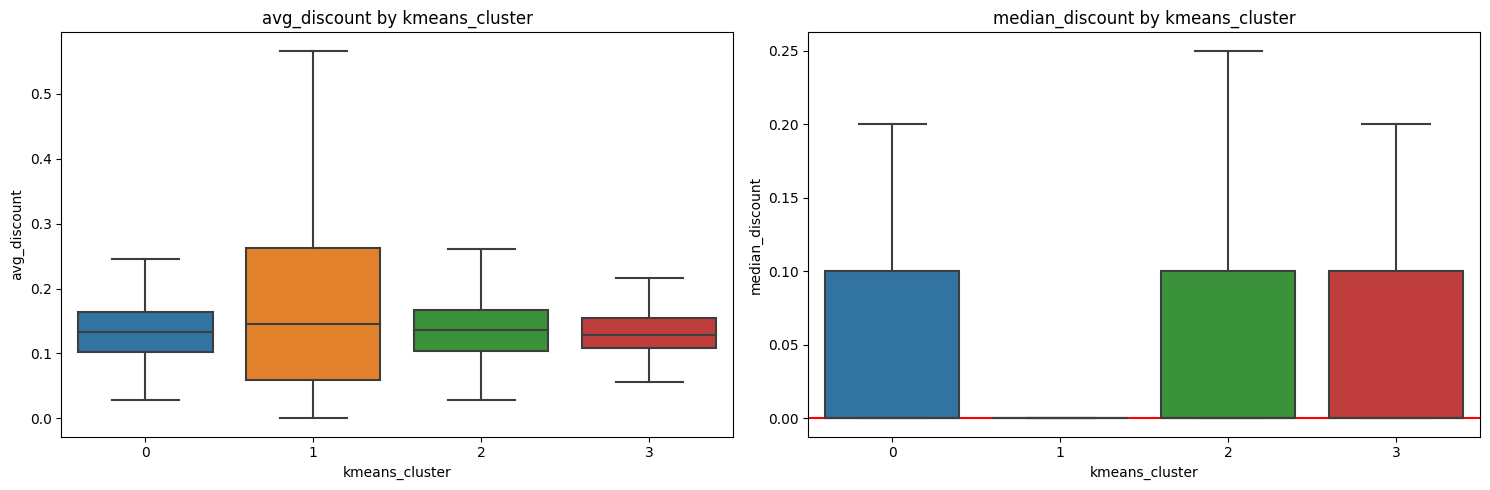

In [42]:
plot_cluster_boxplots(df_customer_abt, 'kmeans_cluster', 'avg_discount', 'median_discount')

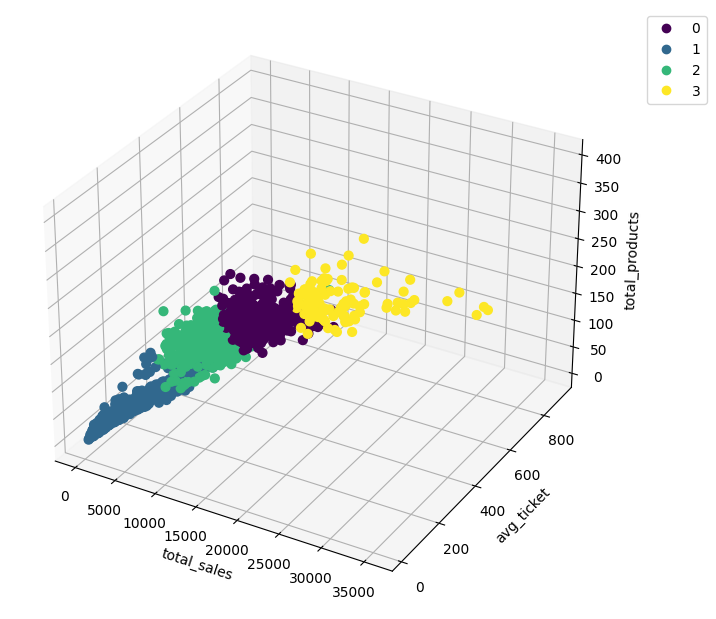

In [35]:
df_temp = df_customer_abt.copy()#[df_customer_abt['value'] < customer_abt['value'].quantile(.95)]

variables = ['total_sales', 'avg_ticket', 'total_products']

x = df_temp[variables[0]]
y = df_temp[variables[1]]
z = df_temp[variables[2]]
# axes instance
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)


# plot
sc = ax.scatter(x, y, z, s=40, c=df_temp['kmeans_cluster'], marker='o', alpha=1)
ax.set_xlabel(variables[0])
ax.set_ylabel(variables[1])
ax.set_zlabel(variables[2])

# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

# save
plt.show()

In [43]:
#### Rescaled

### DBSCAN

### AgglomerativeClustering

## Evaluation Metrics

### Choosing the Right Metric

## Feature Importances

## Cluster Analysis

### Cluster Profiles